In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print("torch version:", torch.__version__)
print("device:", device)


torch version: 2.5.1+cu118
device: cuda


In [7]:
# Data
train_data_path = "/home/kareem/hacking/research/AI_Love/medical_world/generative_ai_book_pytorch/fmnist/fashion-mnist_train.csv"  # Path of data
valid_data_path = "/home/kareem/hacking/research/AI_Love/medical_world/generative_ai_book_pytorch/fmnist/fashion-mnist_test.csv"  # Path of data
print("Train data path:", train_data_path)
print("Valid data path:", valid_data_path)

img_size = 28  # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 30  # Train epochs
learning_rate = 1e-4


Train data path: /home/kareem/hacking/research/AI_Love/medical_world/generative_ai_book_pytorch/fmnist/fashion-mnist_train.csv
Valid data path: /home/kareem/hacking/research/AI_Love/medical_world/generative_ai_book_pytorch/fmnist/fashion-mnist_test.csv


In [8]:
class_list = [
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
class_num = len(class_list)


In [9]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = (
            fashion_df.iloc[:, 1:]
            .values.astype("uint8")
            .reshape(-1, img_size, img_size)
        )
        self.labels = fashion_df.label.values
        print("Image size:", self.images.shape)
        print("--- Label ---")
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])

        if self.transform:
            img = self.transform(img)

        return img, label


In [10]:
dataset = FashionMNIST(train_data_path, img_size)


Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]
)
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)


Image size: (60000, 28, 28)
--- Label ---
label
2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: count, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


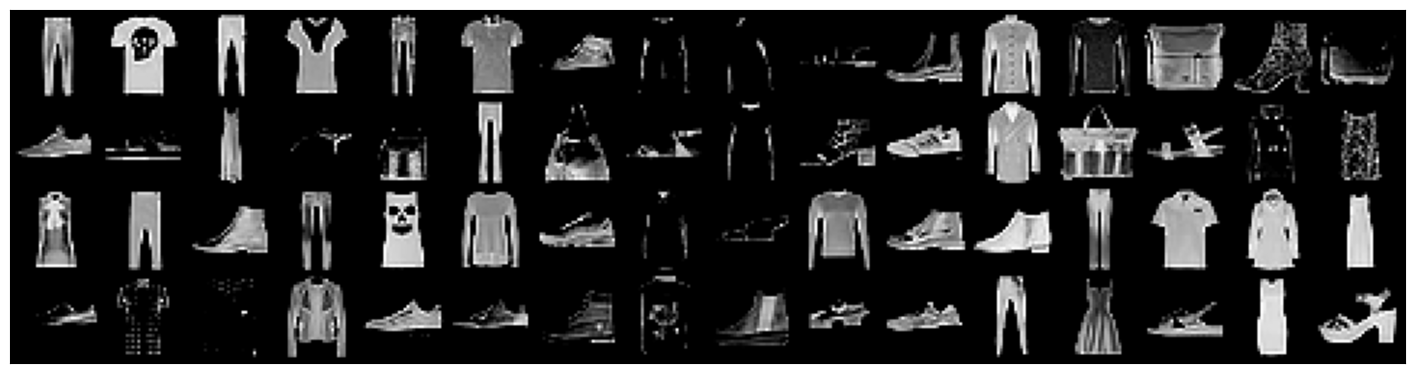

In [12]:
for images,labels in data_loader:
    fig,ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
    break

In [13]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size = img_size

        self.label_emb = nn.Embedding(class_num, class_num)

        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        z = z.view(-1, self.z_size)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(-1, self.img_size, self.img_size)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size

        self.model = nn.Sequential(
            nn.Linear(
                self.img_size * self.img_size + class_num, discriminator_layer_size[0]
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)

        # One-hot vector to embedding vector
        c = self.label_emb(labels)

        # Concat image & label
        x = torch.cat([x, c], 1)

        # Discriminator out
        out = self.model(x)

        return out.squeeze()


In [15]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)


In [16]:
# Loss function
criterion = nn.BCELoss()
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)


In [17]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(
        torch.LongTensor(np.random.randint(0, class_num, batch_size))
    ).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))

    # Backword propagation
    g_loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return g_loss.data


In [18]:
def discriminator_train_step(
    batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels
):
    # Init gradient
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)

    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)

    # Building fake labels
    fake_labels = Variable(
        torch.LongTensor(np.random.randint(0, class_num, batch_size))
    ).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

    # Sum two losses
    d_loss = real_loss + fake_loss

    # Backword propagation
    d_loss.backward()

    # Optimizing discriminator
    d_optimizer.step()

    return d_loss.data


Starting epoch 1...
g_loss: 4.016152381896973, d_loss: 0.38763925433158875


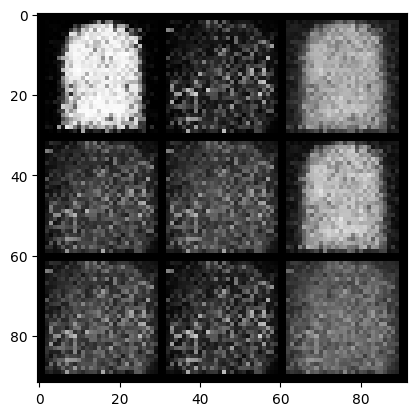

Starting epoch 2...
g_loss: 4.483549118041992, d_loss: 0.3154929280281067


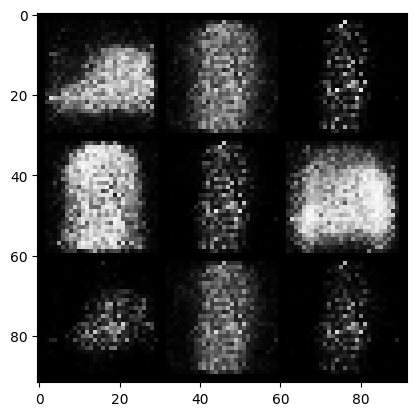

Starting epoch 3...
g_loss: 3.377424478530884, d_loss: 0.22037267684936523


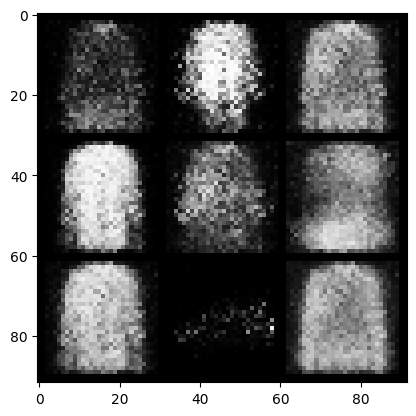

Starting epoch 4...
g_loss: 2.303481101989746, d_loss: 0.5903748273849487


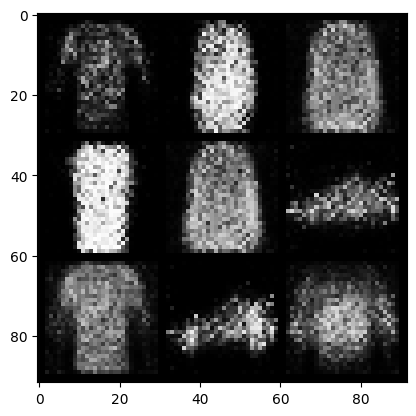

Starting epoch 5...
g_loss: 3.385110378265381, d_loss: 0.44100430607795715


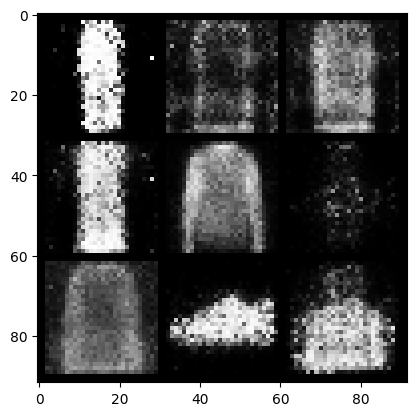

Starting epoch 6...
g_loss: 2.254889965057373, d_loss: 0.5075644254684448


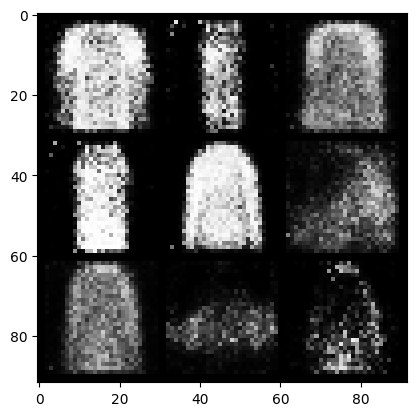

Starting epoch 7...
g_loss: 2.0276358127593994, d_loss: 1.1059956550598145


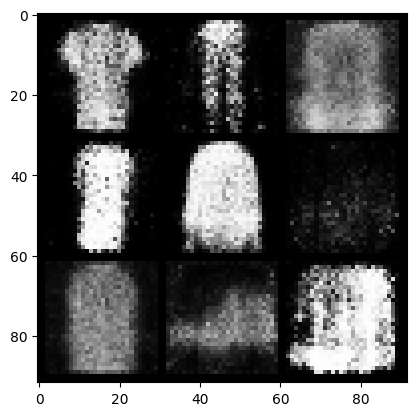

Starting epoch 8...
g_loss: 2.2154033184051514, d_loss: 0.5886948704719543


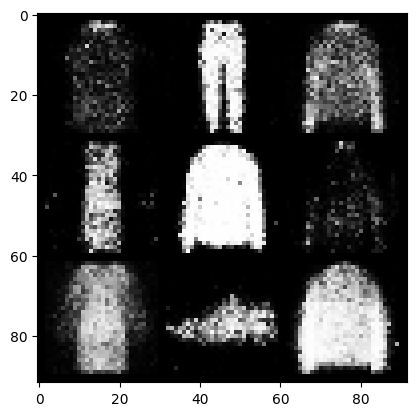

Starting epoch 9...
g_loss: 1.7417809963226318, d_loss: 0.6477476358413696


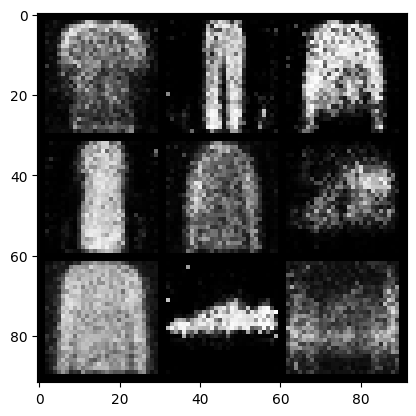

Starting epoch 10...
g_loss: 1.7991704940795898, d_loss: 0.5782439708709717


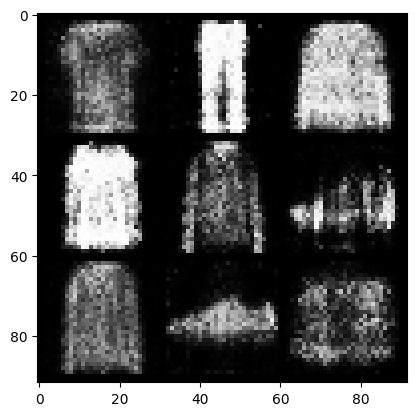

Starting epoch 11...
g_loss: 1.832906723022461, d_loss: 0.634903073310852


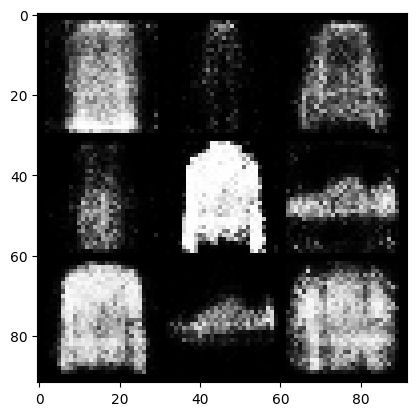

Starting epoch 12...
g_loss: 2.2938761711120605, d_loss: 0.6219972372055054


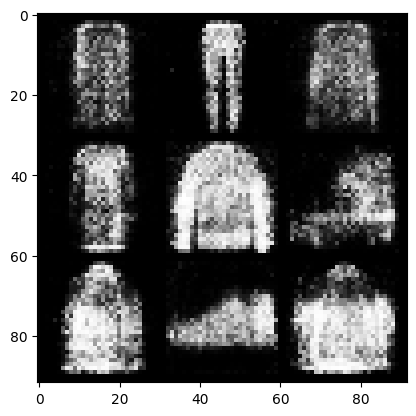

Starting epoch 13...
g_loss: 1.5221521854400635, d_loss: 0.8409547805786133


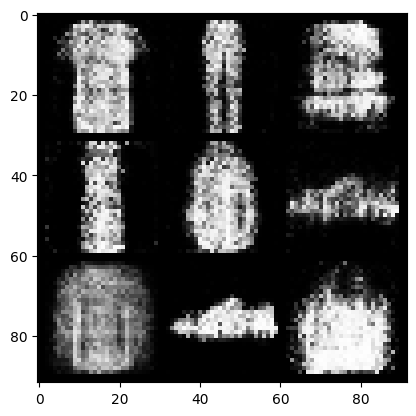

Starting epoch 14...
g_loss: 1.4953627586364746, d_loss: 0.9262709617614746


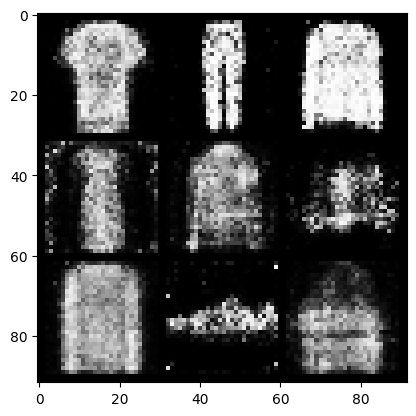

Starting epoch 15...
g_loss: 1.1968269348144531, d_loss: 1.0055149793624878


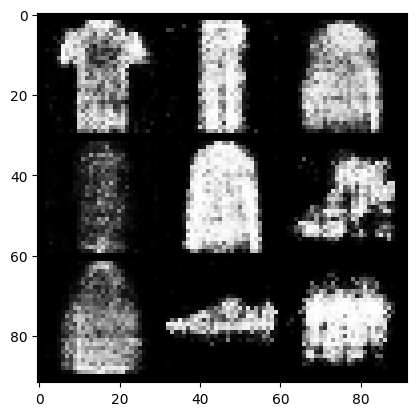

Starting epoch 16...
g_loss: 1.661935806274414, d_loss: 1.0255461931228638


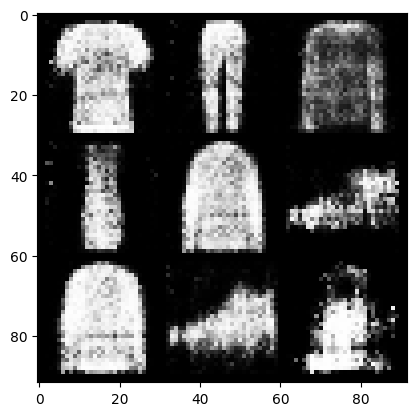

Starting epoch 17...
g_loss: 1.5209167003631592, d_loss: 1.141737699508667


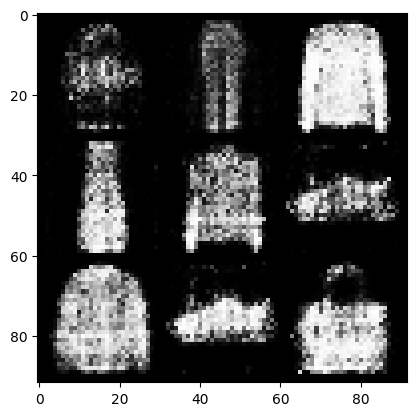

Starting epoch 18...
g_loss: 1.5165364742279053, d_loss: 1.0556879043579102


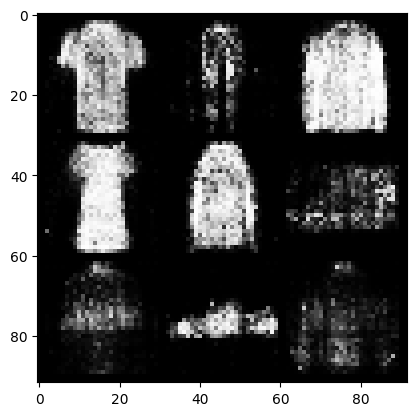

Starting epoch 19...
g_loss: 1.7716946601867676, d_loss: 1.0111775398254395


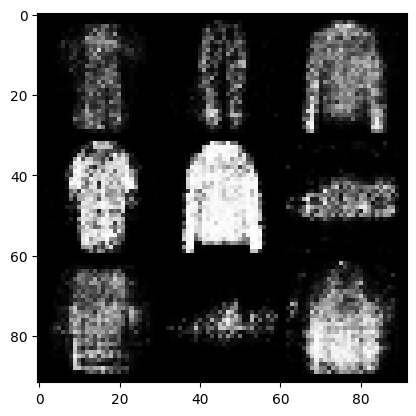

Starting epoch 20...
g_loss: 1.441117763519287, d_loss: 1.0280332565307617


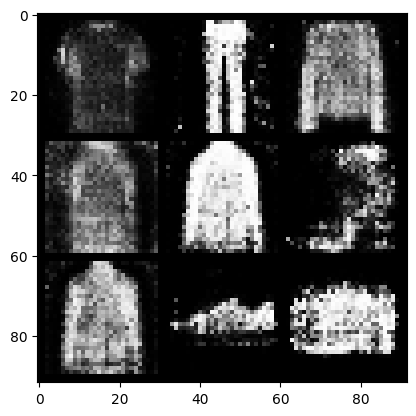

Starting epoch 21...
g_loss: 1.281968116760254, d_loss: 0.8885411024093628


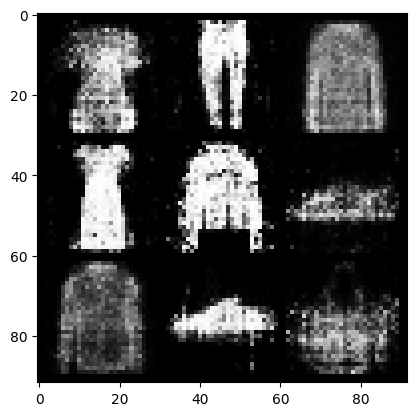

Starting epoch 22...
g_loss: 1.3215093612670898, d_loss: 1.1387205123901367


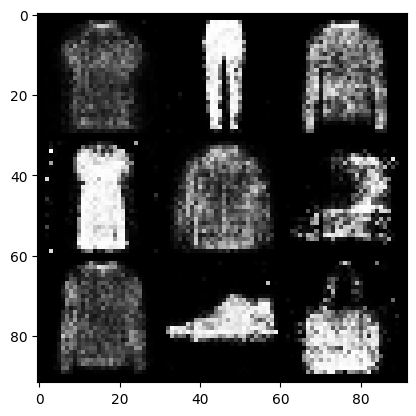

Starting epoch 23...
g_loss: 1.1358035802841187, d_loss: 1.2797431945800781


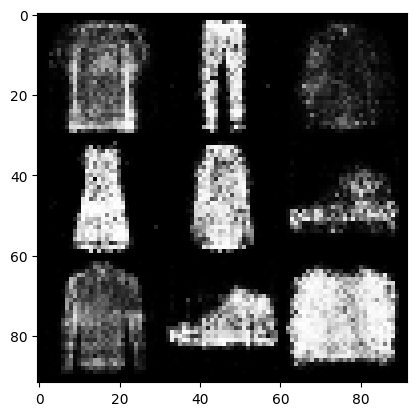

Starting epoch 24...
g_loss: 1.156463861465454, d_loss: 1.0388038158416748


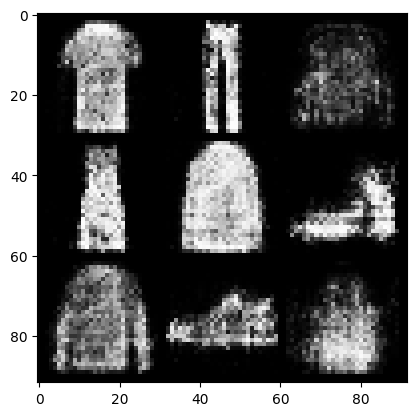

Starting epoch 25...
g_loss: 1.348449468612671, d_loss: 0.8959894776344299


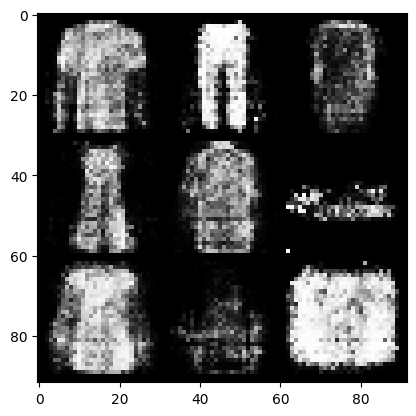

Starting epoch 26...
g_loss: 1.3282451629638672, d_loss: 1.1929266452789307


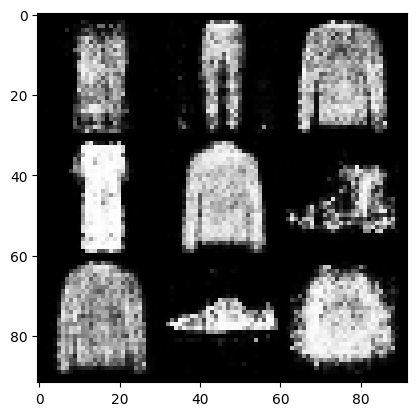

Starting epoch 27...
g_loss: 0.9451954960823059, d_loss: 1.2339833974838257


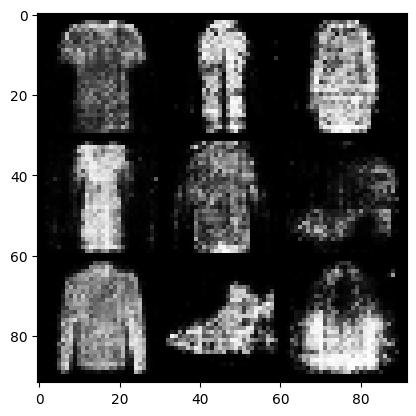

Starting epoch 28...
g_loss: 1.1226658821105957, d_loss: 0.9845001101493835


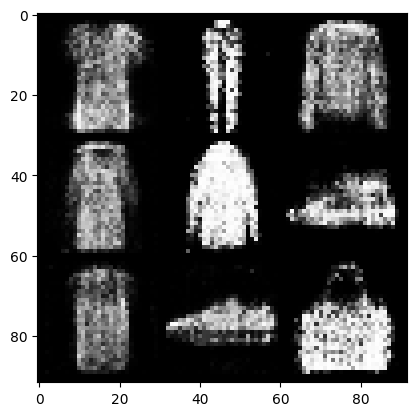

Starting epoch 29...
g_loss: 1.2138222455978394, d_loss: 1.1851096153259277


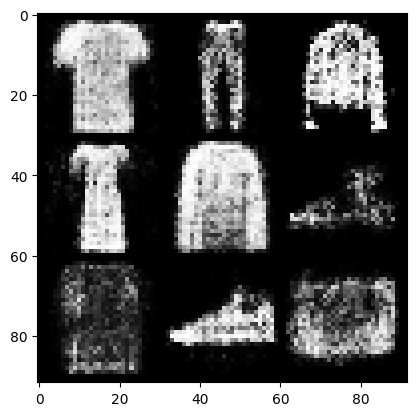

Starting epoch 30...
g_loss: 1.1967978477478027, d_loss: 1.0711239576339722


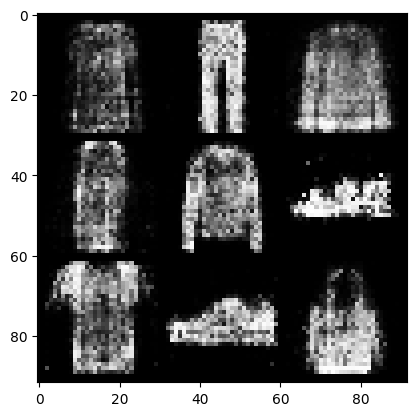

In [19]:
for epoch in range(epochs):
    print("Starting epoch {}...".format(epoch + 1))

    for i, (images, labels) in enumerate(data_loader):
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set generator train
        generator.train()

        # Train discriminator
        d_loss = discriminator_train_step(
            len(real_images),
            discriminator,
            generator,
            d_optimizer,
            criterion,
            real_images,
            labels,
        )

        # Train generator
        g_loss = generator_train_step(
            batch_size, discriminator, generator, g_optimizer, criterion
        )

    # Set generator eval
    generator.eval()

    print("g_loss: {}, d_loss: {}".format(g_loss, d_loss))

    # Building z
    z = Variable(torch.randn(class_num - 1, z_size)).to(device)

    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num - 1))).to(device)

    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()

    # Show images
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1, 2, 0).numpy()
    plt.imshow(grid)
    plt.show()
